In [1]:
library(rwwa)

resid <- function(mdl) {mdl$x - ns_pars(mdl)$loc}

Loading required package: extRemes

Loading required package: Lmoments

Loading required package: distillery


Attaching package: ‘extRemes’


The following objects are masked from ‘package:stats’:

    qqnorm, qqplot




## Load data

In [83]:
ds <- "mswx"

# load data
gmst <- read.table("gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

nino_ann <- read.csv("nino34_ann.csv", col.names = c("year", "nino34_ann"))
nino_djf <- read.csv("nino34_djf.csv", col.names = c("year", "nino34_djf"))

hi <- read.csv(paste0("hi5day_",ds,".csv"), col.names = c("year", "hi"))

# compile into a single dataframe
df <- merge(merge(merge(gmst, nino_ann), nino_djf), hi)

# get covariates
cov_2023 <- df[df$year == 2024, c("gmst", "nino34_djf")]
cov_hist <- cov_2023 - c(1.2,0)
cov_neut <- cov_2023 - c(0, cov_2023$nino34_djf)
cov_neuthist <- cov_2023 - c(1.2, cov_2023$nino34_djf)

# Fit nonstationary model

In [84]:
mdl_gmst <- fit_ns("gev", "shift", df, "hi", c("gmst"))
mdl_ninoann <- fit_ns("gev", "shift", df, "hi", c("gmst", "nino34_ann"))
mdl_ninodjf <- fit_ns("gev", "shift", df, "hi", c("gmst", "nino34_djf"))

In [85]:
# which gives the best overall fit?
cat("GMST only                   ",aic(mdl_gmst),"\n")
cat("GMST + Nino34 (Jul-Jun mean)",aic(mdl_ninoann),"\n")
cat("GMST + Nino34 (DJF mean)    ",aic(mdl_ninodjf),"\n")           # best fit although very similar results to when we use Jul-Jun Nino34

GMST only                    152.8059 
GMST + Nino34 (Jul-Jun mean) 135.4855 
GMST + Nino34 (DJF mean)     131.4159 


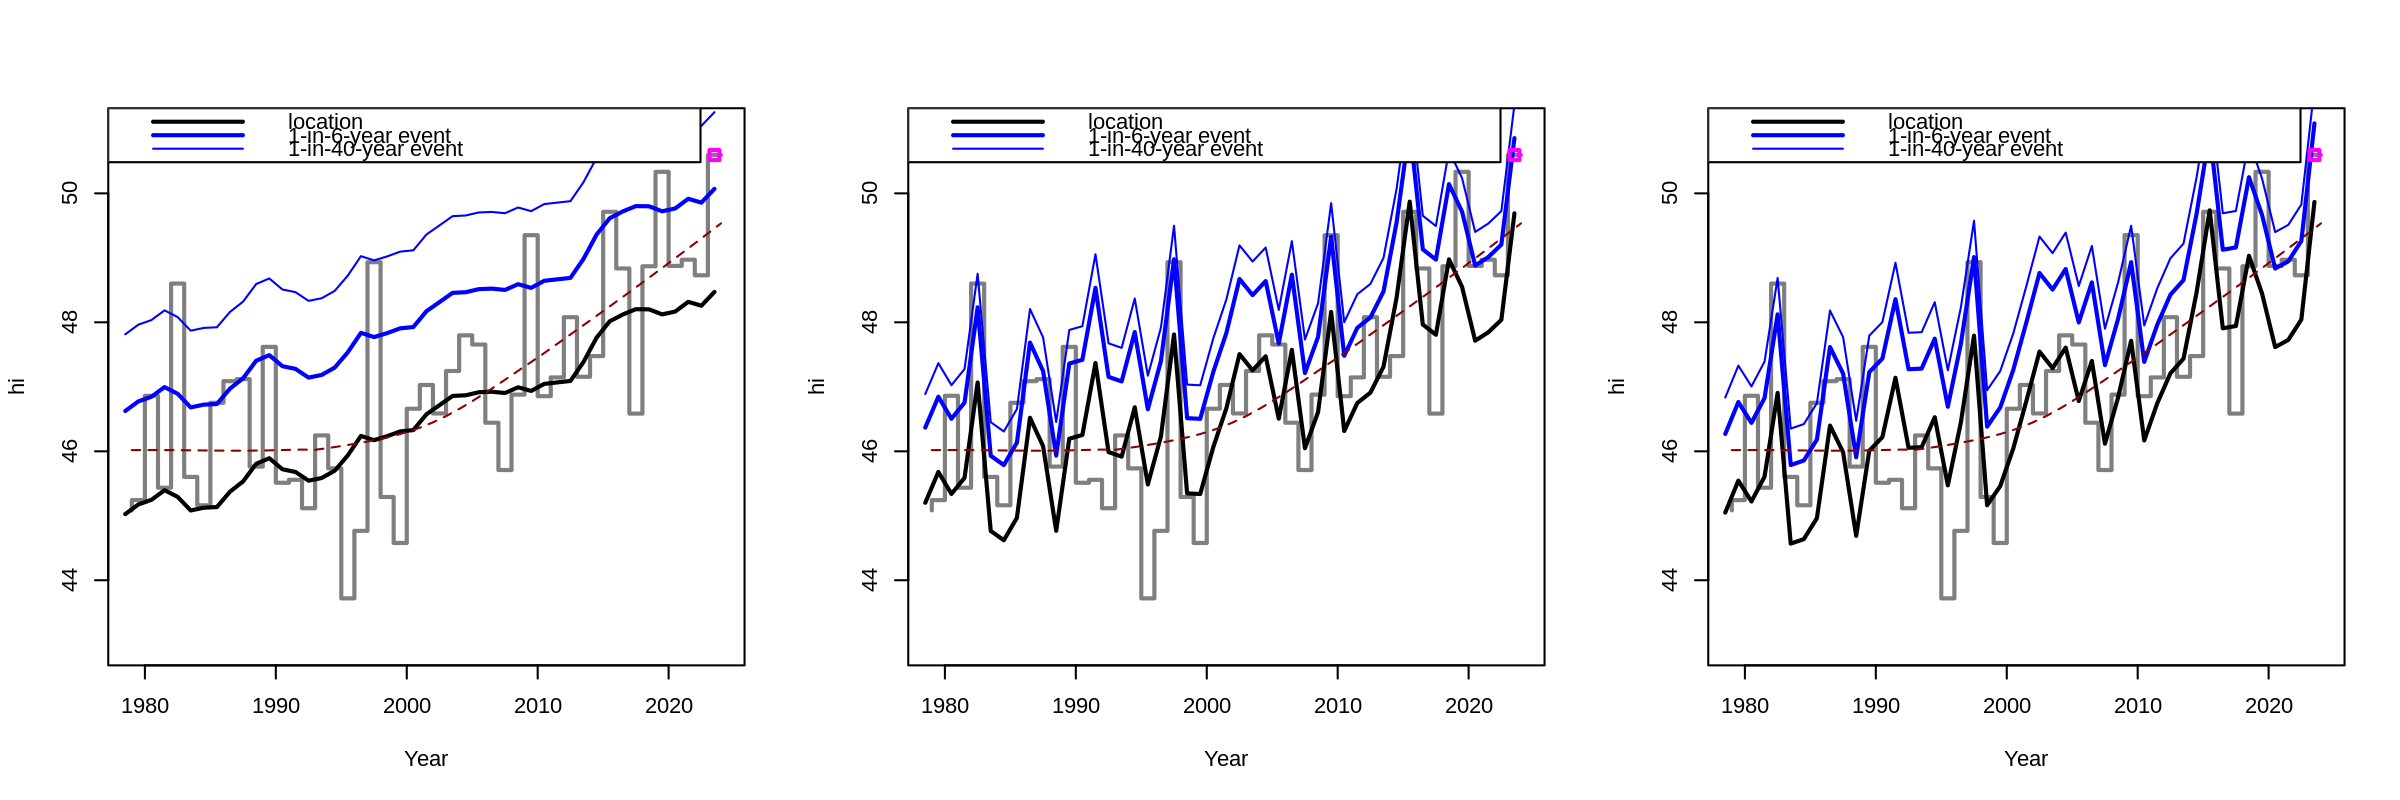

In [86]:
# compare the fitted trends in the three candidate models
prep_window(c(1,3))

# GMST trend vs simple lowess smoother
plot_trend(mdl_gmst)
lines(df$year, lowess(df$year, df$hi)$y, col = "red4", lty = 2)

plot_trend(mdl_ninodjf)
lines(df$year, lowess(df$year, df$hi)$y, col = "red4", lty = 2)

plot_trend(mdl_ninoann)
lines(df$year, lowess(df$year, df$hi)$y, col = "red4", lty = 2)

## Visualise the chosen model

In [87]:
df$nino <- df$nino34_djf
mdl <- fit_ns("gev", "shift", df, "hi", c("gmst", "nino"))

cov_2023 <- df[df$year == 2024, c("gmst", "nino")]
cov_cf <- rbind("hist" = cov_2023 - c(1.2,0), "neut" = cov_2023 - c(0, cov_2023$nino))

In [88]:
# any trends in residuals?
prep_window(c(1,3))

ylim <- c(40,60)

png(paste0("fig/fitted-trend_",ds,".png"), height = 480, width = 480*3); par(mfrow = c(1,3), cex.main = 1.5, cex = 1.2, cex.lab = 1.4, cex.axis = 1.3); {

    par(oma = c(0,0,2,0))
    
    plot_trend(mdl, ylim = ylim, main = "over time")
    plot_covtrend(mdl, xcov = "gmst", plot_cov = data.frame(gmst = df$gmst, nino = mean(df$nino)), ylim = ylim, main = "vs GMST")
    lines(df$gmst[order(df$gmst)], ns_pars(mdl_gmst)$loc[order(df$gmst)], col = "forestgreen", lwd = 3)
    lines(df$gmst[order(df$gmst)], eff_return_level(mdl_gmst, 6)[order(df$gmst)], col = "forestgreen", lwd = 2)
    lines(df$gmst[order(df$gmst)], eff_return_level(mdl_gmst, 40)[order(df$gmst)], col = "forestgreen", lwd = 1)

    plot_covtrend(mdl, xcov = "nino", plot_cov = data.frame(gmst = mean(df$gmst), nino = df$nino), ylim = ylim, main = "vs Nino")
    abline(v = 0, lty = 2)
    
    mtext(paste0("Fitted trend: hi ~ gmst + nino3.4 (",toupper(ds),")"), outer = T, font = 2, cex = 2)
}; dev.off()

png 
  2

## Check model fit

In [80]:
### any trends in residuals?
prep_window(c(1,3))

ylim <- c(-2.5,4.5)

png(paste0("fig/residuals_",ds,".png"), height = 480, width = 480*3); par(mfrow = c(1,3), cex.main = 1.5, cex = 1.2, cex.lab = 1.4, cex.axis = 1.3); {
    par(oma = c(0,0,2,0))

    plot(df$year, resid(mdl), ylim = ylim, main = "vs time", col = "darkblue", pch = 20)
    # points(df$year[1:74], resid(mdl_excl), col = "darkred", pch = 4)
    points(2023, resid(mdl)[df$year == 2023], col = "magenta", pch = 0)
    lines(df$year, fitted(loess(resid(mdl) ~ df$year)), col = "blue", lwd = 2)
    abline(h = 0, lty = 2)
    
    plot(df$gmst, resid(mdl), ylim = ylim, main = "vs GMST", col = "darkblue", pch = 20)
    points(df$gmst[df$year == 2023], resid(mdl)[df$year == 2023], col = "magenta", pch = 0)
    # points(df$gmst[1:74], resid(mdl_excl), col = "darkred", pch = 4)
    lines(df$gmst[order(df$gmst)], fitted(loess(resid(mdl) ~ df$gmst))[order(df$gmst)], col = "blue", lwd = 2)
    abline(h = 0, lty = 2)
        
    plot(df$nino, resid(mdl), ylim = ylim, main = "vs Nino3.4", col = "darkblue", pch = 20)
    points(df$nino[df$year == 2023], resid(mdl)[df$year == 2023], col = "magenta", pch = 0)
    # points(df$nino34_djf[1:74], resid(mdl_excl), col = "darkred", pch = 4)
    lines(df$nino[order(df$nino)], fitted(loess(resid(mdl) ~ df$nino))[order(df$nino)], col = "blue", lwd = 2)
    abline(h = 0, v = 0, lty = 2)
    
    mtext(paste0("Trend in residuals (",toupper(ds),")"), outer = T, font = 2, cex = 2)
    
    # slight downward trend in residuals when 2023 event is included - almost flat when 2023 is excluded from model fit
}; dev.off()

png 
  2

In [81]:
# standard deviation of the residuals - pretty flat either way
prep_window(c(1,3))

ylim <- c(-2.5,4.5)
png(paste0("fig/residual-sd_",ds,".png"), height = 480, width = 480*3); par(mfrow = c(1,3), cex.main = 1.5, cex = 1.2, cex.lab = 1.4, cex.axis = 1.3); {
    par(oma = c(0,0,2,0))
    
    df <- df[order(df$year),]
    plot(df$year, resid(mdl_ninodjf), ylim = ylim, pch = 20, main = "vs time")
    lines(df$year[8:(nrow(df)-8)], sapply(1:(nrow(df)-15), function(ys) { sd(resid(mdl)[ys+(0:15)]) }), type = "l", lwd = 2, col = "blue")
    abline(h = 0, lty = 2)
    
    df <- df[order(df$gmst),]
    plot(df$gmst, resid(mdl_ninodjf), ylim = ylim, pch = 20, main = "vs GMST")
    lines(df$gmst[8:(nrow(df)-8)], sapply(1:(nrow(df)-15), function(ys) { sd(resid(mdl)[ys+(0:15)]) }), type = "l", lwd = 2, col = "blue")
    abline(h = 0, lty = 2)
    
    df <- df[order(df$nino),]
    plot(df$nino, resid(mdl_ninodjf), ylim = ylim, pch = 20, main = "vs Nino3.43")
    lines(df$nino[8:(nrow(df)-8)], sapply(1:(nrow(df)-15), function(ys) { sd(resid(mdl)[ys+(0:15)]) }), type = "l", lwd = 2, col = "blue")
    abline(h = 0, lty = 2)

    df <- df[order(df$year),]

    mtext(paste0("Rolling SD of residuals (",toupper(ds),")"), outer = T, font = 2, cex = 2)

}; dev.off()

png 
  2

In [29]:
ylim <- c(40,60)
prep_window(c(1,3))

png(paste0("fig/returnlevels_",ds,".png"), height = 480, width = 480 * 2.5); par(cex.main = 1.5, cex = 1.2, cex.lab = 1.6, cex.axis = 1.3); {
    
    par(mfrow = c(1,2), oma = c(0,0,2,0))
    plot_returnlevels(mdl, cov = cov_2023, cov_cf = cov_cf["hist",,drop=F], ylim = ylim, nsamp = 1000,
                     main = "Change due to 1.2deg change in GMST")

    plot_returnlevels(mdl, cov = cov_2023, cov_cf = cov_cf["neut",,drop=F], ylim = ylim, nsamp = 1000,
                     main = "Change due to 2024 El Nino")

    mtext(toupper(ds), outer = T, font = 2, cex = 2)

}; dev.off()

png 
  2

### Parameter estimates

In [53]:
gmst <- read.table("gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2024]

nino <- read.csv("nino34_djf.csv", col.names = c("year", "nino"))

hi_era5 <- read.csv("hi5day_era5.csv", col.names = c("year", "hi"))
hi_mswx <- read.csv("hi5day_mswx.csv", col.names = c("year", "hi"))

# compile into a single dataframe
df_era5 <- merge(merge(gmst, nino), hi_era5)
df_mswx <- merge(merge(gmst, nino), hi_mswx)

cov_2023 <- df[df$year == 2024, c("gmst", "nino")]
cov_cf <- rbind("hist" = cov_2023 - c(1.2,0), "neut" = cov_2023 - c(0, cov_2023$nino))

In [57]:
res_era5_gmstonly <- boot_ci(fit_ns("gev", "shift", df_era5, "hi", c("gmst")), cov = cov_2023, cov_cf = cov_cf, nsamp = 10)
res_era5_gmstnino <- boot_ci(fit_ns("gev", "shift", df_era5, "hi", c("gmst", "nino")), cov = cov_2023, cov_cf = cov_cf, nsamp = 10)

res_mswx_gmstonly <- boot_ci(fit_ns("gev", "shift", df_mswx, "hi", c("gmst")), cov = cov_2023, cov_cf = cov_cf, nsamp = 10)
res_mswx_gmstnino <- boot_ci(fit_ns("gev", "shift", df_mswx, "hi", c("gmst", "nino")), cov = cov_2023, cov_cf = cov_cf, nsamp = 10)

In [71]:
plot_pars <- c("alpha_gmst", "alpha_nino", "shape", "return_period", "PR_hist",  "PR_neut", "dI_abs_hist", "dI_abs_neut")
prep_window(c(1,4)); 

png("fig/parameter-estimates.png", height = 480, width = 480*3); par(cex.main = 2, cex = 1.2, cex.lab = 1.6, cex.axis = 1.3, mar = c(12,3,3,1)); {
    par(mfrow = c(1,length(plot_pars)))

    for (r in plot_pars) {
        res <- t(sapply(list("ERA5 GMST only" = res_era5_gmstonly, 
                             "MSWX GMST only" = res_mswx_gmstonly, 
                             "ERA5 GMST + nino" = res_era5_gmstnino,
                             "MSWX GMST + nino" = res_mswx_gmstnino), function(mres) {
                    if (r %in% rownames(mres)) mres[r,] else setNames(rep(NA, 3), colnames(res))
                }))
        res[!is.finite(res[,"est"]),"est"] <- res[!is.finite(res[,"est"]),"2.5%"]
        res[!is.finite(res[,"97.5%"]),"97.5%"] <- res[!is.finite(res[,"97.5%"]),"est"]
        res[!is.finite(res)] <- NA
        res[res == 1] <- NA
        res[res == 0] <- NA
        
        n <- nrow(res)
        plot(0, type = "n", ylim = range(res, na.rm = T), xlim = c(0,n+1), main = r, xaxt = "n", xlab = "", ylab = "")
        axis(1, at = 1:n, labels = rownames(res), las = 2)
        segments(x0 = 1:n, y0 = res[,"2.5%"], y1 = res[,"97.5%"], lwd = 8, col = adjustcolor(c("blue", "red"), alpha = 0.4))
        points(1:n, res[,"est"], pch = 20, cex = 2)
        if(grepl("PR", r)) abline(h = 1, lty = 2) else abline(h = 0, lty = 2)
    }
}; dev.off()

png 
  2

# Nino3.4, NinoAtl or SSTs?

In [ ]:
# load data
gmst <- read.table("gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

nino_djf <- read.csv("nino34_djf.csv", col.names = c("year", "nino34_djf"))
sst_djf <- read.csv("nino-djf_loess-detrended.csv", col.names = c("year", "sst_djf"))

hi <- read.csv("hi5day.csv", col.names = c("year", "hi"))

# compile into a single dataframe
df <- merge(merge(merge(gmst, nino_djf), sst_djf), hi)

# get covariates
cov_2023 <- df[df$year == 2023, c("gmst", "nino34_djf", "sst_djf")]
cov_hist <- cov_2023 - c(1.2,0,0)
cov_neut <- cov_2023 - c(0, cov_2023$nino34_djf, cov_2023$sst_djf)

In [ ]:
# get 3-year smoothed Atlantic Nino as well
nino_atl <- read.csv("../10_misc/detrended_nino34/nino-atlantic.csv")
nino_atl$nino_3 <- filter(nino_atl$nino_atl, rep(1/3,3), sides = 1)
nino_atl <- nino_atl[!is.na(nino_atl$nino_3),]

nino_atl <- nino_atl[substr(nino_atl$time,6,7) == "02",]
nino_atl$year <- as.integer(substr(nino_atl$time,1,4))-1


nino_atl$nino_atl <- nino_atl$nino_3 - fitted(loess(nino_3 ~ year, nino_atl))

df <- merge(df, nino_atl[,c("year", "nino_atl")])

In [ ]:
prep_window(c(1,2))
plot(df$nino34_djf, df$sst_djf, asp = 1, xlim = c(-3,3), ylim = c(-3,3))
points(df[df$year == 2023,c("nino34_djf", "sst_djf")], col = "magenta", pch = 0, lwd = 2)
abline(0,1)
abline(h = 0, v = 0, lty = 2)

plot(df$nino34_djf, df$nino_atl, asp = 1, xlim = c(-3,3), ylim = c(-3,3))
points(df[df$year == 2023,c("nino34_djf", "nino_atl")], col = "magenta", pch = 0, lwd = 2)
abline(0,1)
abline(h = 0, v = 0, lty = 2)

## Fit nonstationary model

In [159]:
mdl_gmst <- fit_ns("gev", "shift", df, "hi", c("gmst"))
mdl_ninodjf <- fit_ns("gev", "shift", df, "hi", c("gmst", "nino34_djf"))
mdl_sstdjf <- fit_ns("gev", "shift", df, "hi", c("gmst", "sst_djf"))
mdl_ninoexcl <- fit_ns("gev", "shift", df[df$year < 2023,], "hi", c("gmst", "nino34_djf"), ev = hi$hi[hi$year == 2023])
mdl_sstexcl <- fit_ns("gev", "shift", df[df$year < 2023,], "hi", c("gmst", "sst_djf"), ev = hi$hi[hi$year == 2023])

mdl_ninoatl <- fit_ns("gev", "shift", df, "hi", c("gmst", "nino_atl"))


In [160]:
# which gives the best overall fit?
cat("GMST only                ",aic(mdl_gmst),"\n")
cat("GMST + Nino34 (DJF mean) ",aic(mdl_ninodjf),"\n") 
cat("GMST + SST34 (DJF mean)  ",aic(mdl_sstdjf),"\n")           # best fit although very similar results to when we use annual Nino34
cat("\n")
cat("GMST + Nino34 (DJF mean) ",aic(mdl_ninoexcl),"\n")      
cat("GMST + SST34 (DJF mean)  ",aic(mdl_sstexcl),"\n")          # best fit although very similar results to when we use annual Nino34
cat("\n")
cat("GMST + Atlantic Nino (DJF mean) ",aic(mdl_ninoatl),"\n")      # better than Nino3.4 but not as good as the Nino SSTs

GMST only                 266.8832 
GMST + Nino34 (DJF mean)  256.228 
GMST + SST34 (DJF mean)   251.787 

GMST + Nino34 (DJF mean)  226.4017 
GMST + SST34 (DJF mean)   220.2822 

GMST + Atlantic Nino (DJF mean)  255.8158 


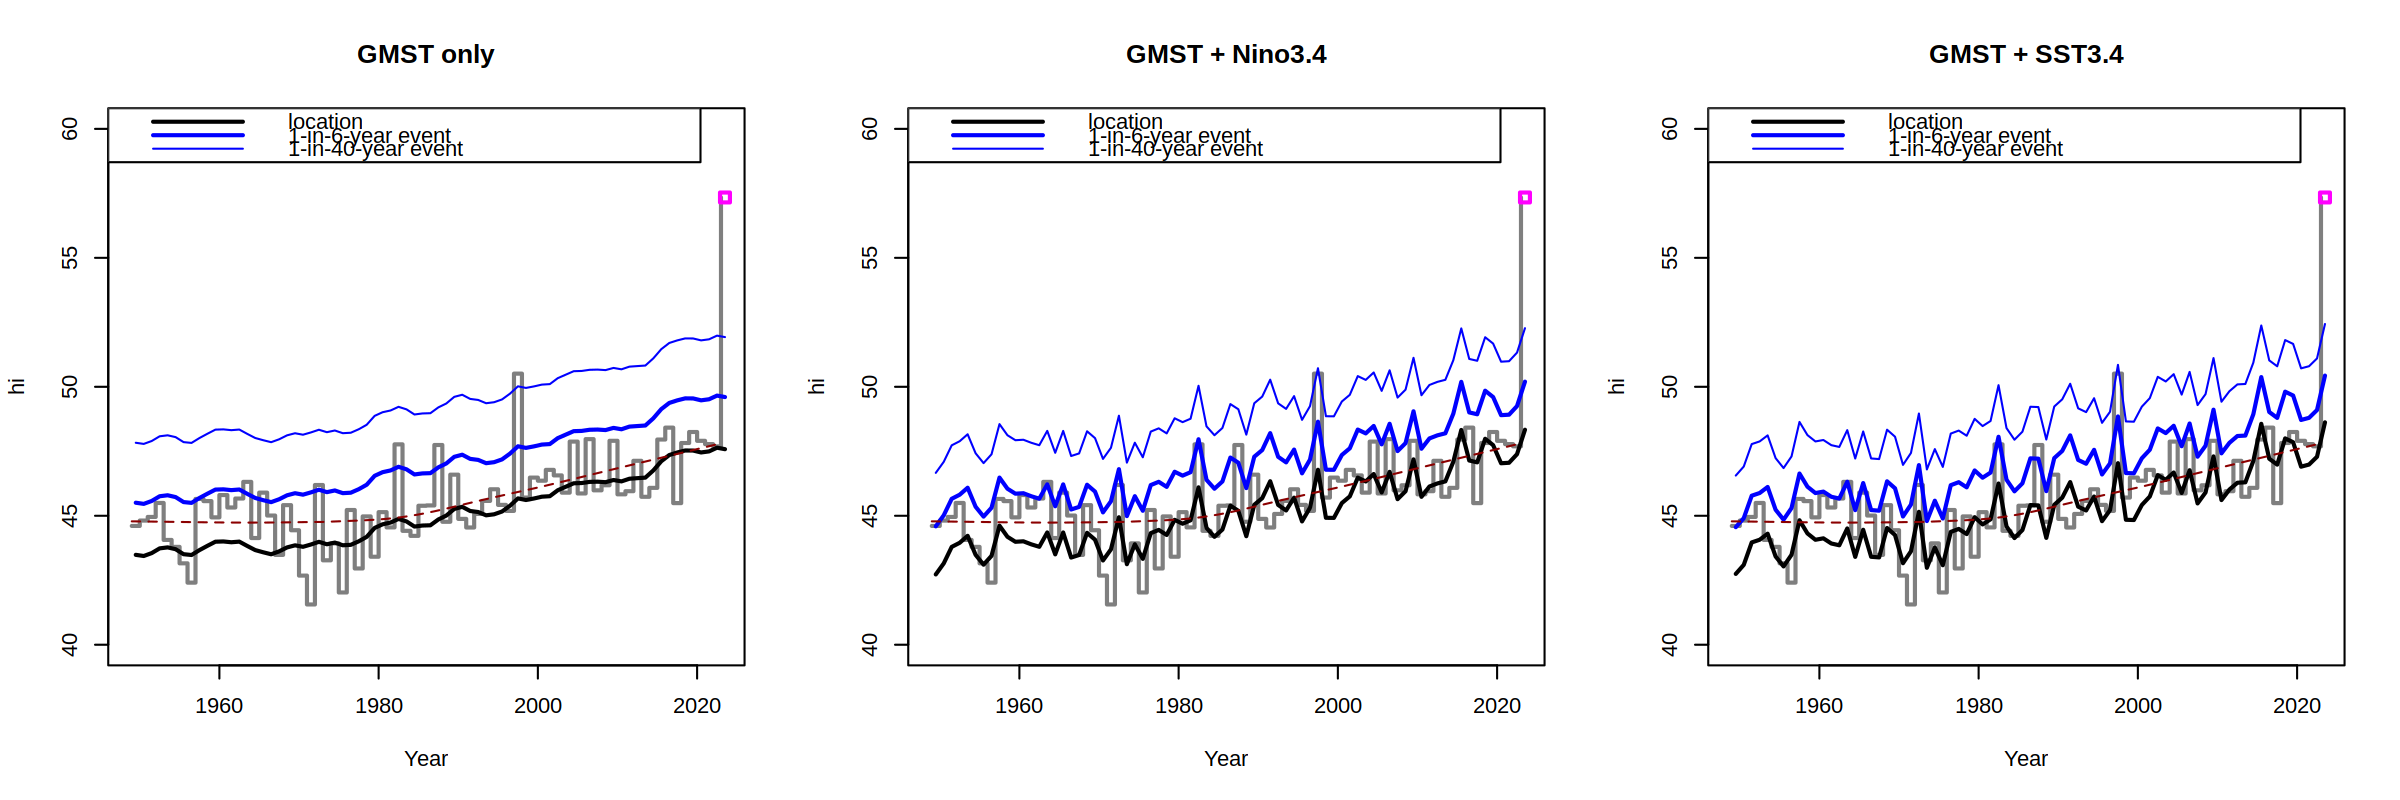

In [85]:
# compare the fitted trends in the three candidate models
prep_window(c(1,3))

# GMST trend vs simple lowess smoother
plot_trend(mdl_gmst, main = "GMST only")
lines(df$year, lowess(df$year, df$hi)$y, col = "red4", lty = 2)

plot_trend(mdl_ninodjf, main = "GMST + Nino3.4")
lines(df$year, lowess(df$year, df$hi)$y, col = "red4", lty = 2)

# sst3.4 means detrended using loess smoother, rather than by subtracting tropical SSTs
plot_trend(mdl_sstdjf, main = "GMST + SST3.4")
lines(df$year, lowess(df$year, df$hi)$y, col = "red4", lty = 2)


In [93]:
# any trends in residuals?
prep_window(c(1,3))

ylim <- c(40,60)

png("fig/fitted-trend_sst.png", height = 480, width = 480*3); par(mfrow = c(1,3), cex.main = 1.5, cex = 1.2, cex.lab = 1.4, cex.axis = 1.3); {

    par(oma = c(0,0,2,0))
    
    plot_trend(mdl_ninodjf, ylim = ylim, main = "over time")
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    o <- order(df$gmst)
    gmst_cov <- data.frame(gmst = df$gmst, sst_djf = mean(df$sst_djf))[o,]
    plot(df$gmst, df$hi, ylim = ylim, main = "vs GMST", pch = 20)
    points(df[df$year == 2023, c("gmst", "hi")], col = "magenta", pch = 0)
    lines(df$gmst[o], ns_pars(mdl_sstdjf, fixed_cov = gmst_cov)$loc, lwd = 2)
    lines(df$gmst[o], eff_return_level(mdl_sstdjf, 6, fixed_cov = gmst_cov), lwd = 2, col = "blue")
    lines(df$gmst[o], eff_return_level(mdl_sstdjf, 40, fixed_cov = gmst_cov), lwd = 1, col = "blue")
    lines(df$gmst[o], ns_pars(mdl_gmst, fixed_cov = gmst_cov[,"gmst",drop=F])$loc, lwd = 2, col = "forestgreen")
    lines(df$gmst[o], eff_return_level(mdl_gmst, 6, fixed_cov = gmst_cov[,"gmst",drop=F]), lwd = 2, col = "forestgreen")
    lines(df$gmst[o], eff_return_level(mdl_gmst, 40, fixed_cov = gmst_cov[,"gmst",drop=F]), lwd = 1, col = "forestgreen")
    legend("topleft", c("GMST only", "SST3.4 + GMST"), lty =1, col = c("forestgreen", "blue"))

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    o <- order(df$nino34_djf)
    nino_cov <- data.frame(gmst = mean(df$gmst), sst_djf = df$sst_djf)[o,]
    plot(df$sst_djf, df$hi, ylim = ylim, main = "vs SST34 (DJF)", pch = 20)
    points(df[df$year == 2023, c("sst_djf", "hi")], col = "magenta", pch = 0)
    lines(df$sst_djf[o], ns_pars(mdl_sstdjf, fixed_cov = nino_cov)$loc, lwd = 2)
    lines(df$sst_djf[o], eff_return_level(mdl_sstdjf, 6, fixed_cov = nino_cov), lwd = 2, col = "blue")
    lines(df$sst_djf[o], eff_return_level(mdl_sstdjf, 40, fixed_cov = nino_cov), lwd = 1, col = "blue")
    abline(v = 0, lty = 2)
    
    mtext("Fitted trend: hi ~ gmst + sst3.4", outer = T, font = 2, cex = 2)
}; dev.off()

png 
  2

### Parameter estimates

In [ ]:
# have to fix RP when excluding event, otherwise PR etc will fail

set.seed(42)
res_gmst <- boot_ci(mdl_gmst, cov = cov_2023, cov_cf = cov_hist, nsamp = 1000)
res_nino <- boot_ci(mdl_ninodjf, cov = cov_2023, cov_cf = cov_hist, nsamp = 1000)
res_sst <- boot_ci(mdl_sstdjf, cov = cov_2023, cov_cf = cov_hist, nsamp = 1000)
res_excl <- boot_ci(mdl_sstexcl, cov = cov_2023, cov_cf = cov_hist, nsamp = 1000, rp = 5000, ev = eff_return_level(mdl_sstexcl, 100, fixed_cov = cov_2023))

In [ ]:
# estimate PR & change in intensity due to positive Nino phase
res_neut_nino <- boot_ci(mdl_ninodjf, cov = cov_2023, cov_cf = cov_neut, nsamp = 1000)
res_neut_sst <- boot_ci(mdl_sstdjf, cov = cov_2023, cov_cf = cov_neut, nsamp = 1000)
res_neut_excl <- boot_ci(mdl_sstexcl, cov = cov_2023, cov_cf = cov_neut, nsamp = 1000, rp = 5000, ev = eff_return_level(mdl_sstexcl, 100, fixed_cov = cov_2023))

In [234]:
res_nino <- res_nino[1:11,]
res_sst <- res_sst[1:11,]
res_excl <- res_excl[1:11,]
rownames(res_neut_nino) <- gsub("_nino", "", rownames(res_neut_nino))
rownames(res_neut_sst) <- gsub("_nino", "", rownames(res_neut_sst))
rownames(res_neut_excl) <- gsub("_nino", "", rownames(res_neut_excl))

rownames(res_neut_nino) <- paste0(rownames(res_neut_nino), "_nino")
rownames(res_neut_sst) <- paste0(rownames(res_neut_sst), "_nino")
rownames(res_neut_excl) <- paste0(rownames(res_neut_excl), "_nino")

res_nino <- rbind(res_nino, res_neut_nino[c("PR_nino", "dI_abs_nino"),])
res_sst <- rbind(res_sst, res_neut_sst[c("PR_nino", "dI_abs_nino"),])
res_excl <- rbind(res_excl, res_neut_excl[c("PR_nino", "dI_abs_nino"),])

rownames(res_nino) <- gsub("sst_djf", "nino/sst", rownames(res_sst))
rownames(res_sst) <- gsub("sst_djf", "nino/sst", rownames(res_sst))
rownames(res_excl) <- gsub("sst_djf", "nino/sst", rownames(res_excl))

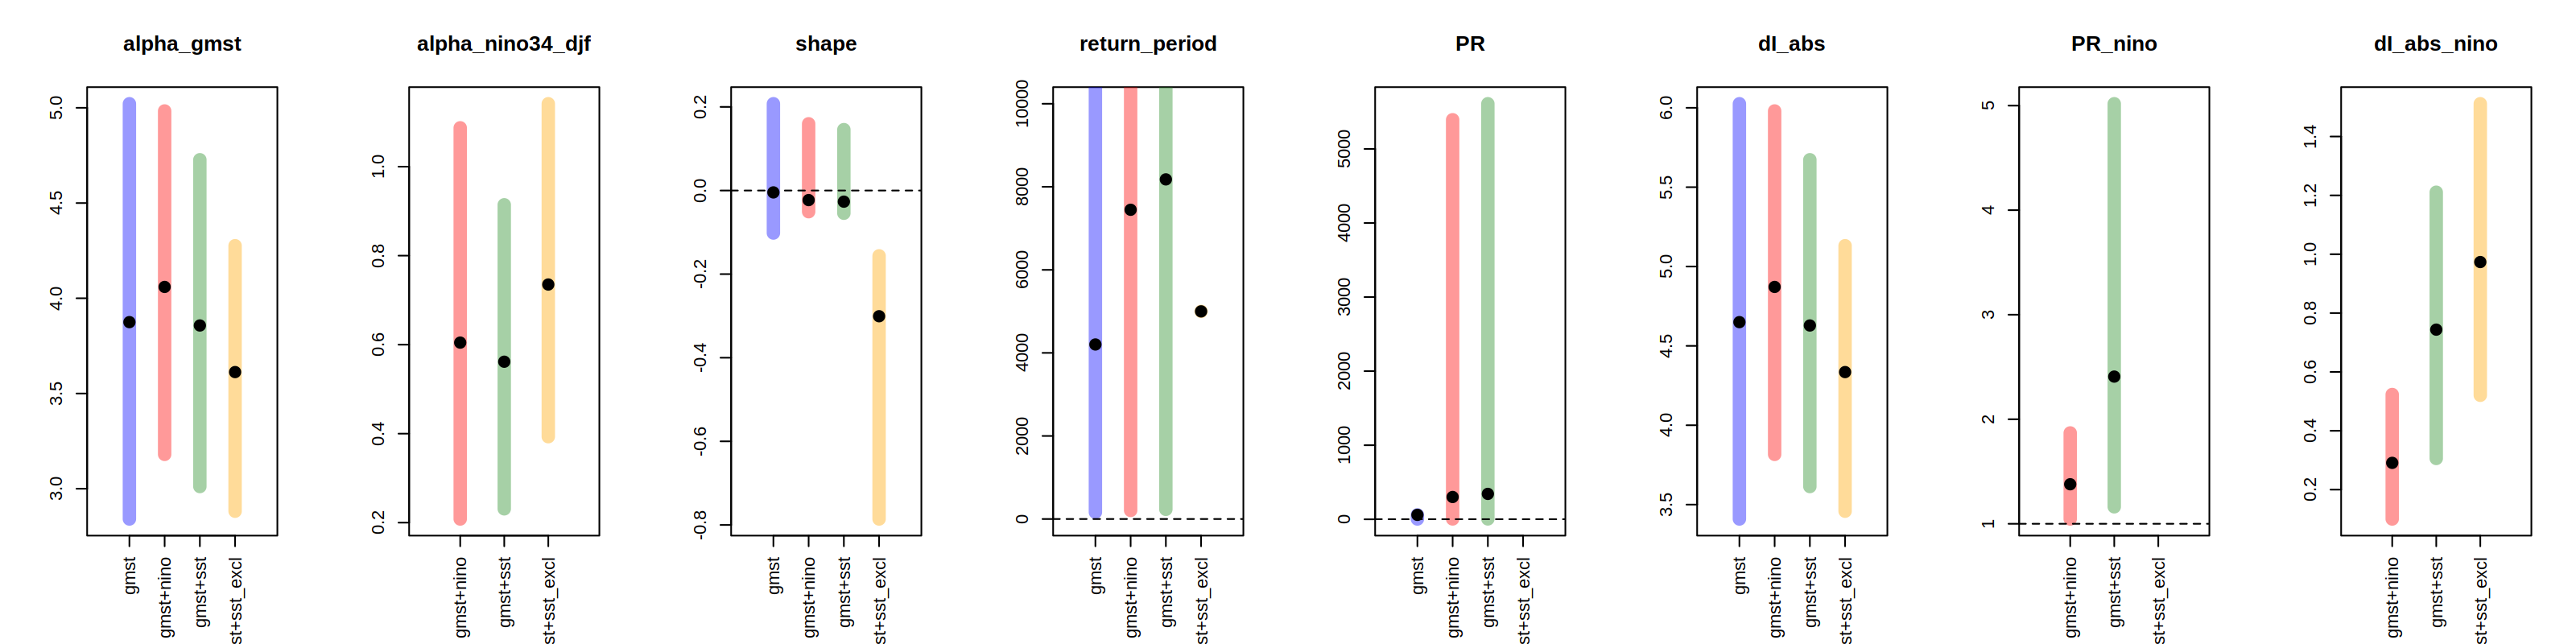

In [238]:
plot_pars <- c("alpha_gmst", "alpha_nino34_djf", "shape", "return_period", "PR", "dI_abs", "PR_nino", "dI_abs_nino")
prep_window(c(1,4)); 

# png("fig/parameter-estimates_sst.png", height = 480, width = 480*3); par(cex.main = 2, cex = 1.2, cex.lab = 1.6, cex.axis = 1.3, mar = c(8,3,3,1)); {
    par(mfrow = c(1,length(plot_pars)))

    for (r in plot_pars) {
        cols <- c("red", "forestgreen", "orange")
        res <- rbind("gmst+nino" = res_nino[r,], "gmst+sst" = res_sst[r,], "gmst+sst_excl" = res_excl[r,])
        if(r %in% rownames(res_gmst)) {
            res <- rbind("gmst" = res_gmst[r,], res)
            cols <- c("blue", cols)
            }
        
        res[,"bestimate"][!is.finite(res[,"bestimate"])] <- res[!is.finite(res[,"bestimate"]),"2.5%"]
        res[,"97.5%"][!is.finite(res[,"97.5%"])] <- res[!is.finite(res[,"97.5%"]),"bestimate"]

        if(r == "return_period") {
            ylim <- c(0,10000)
        } else {
            ylim <- range(res, na.rm = T)
        }
        
        
        n <- nrow(res)
        plot(0, type = "n", ylim = ylim, xlim = c(0,n+1), main = r, xaxt = "n", xlab = "", ylab = "")
        axis(1, at = 1:n, labels = rownames(res), las = 2)
        segments(x0 = 1:n, y0 = res[,"2.5%"], y1 = res[,"97.5%"], lwd = 8, col = adjustcolor(cols, alpha = 0.4))
        points(1:n, res[,"bestimate"], pch = 20, cex = 2)
        if(grepl("PR", r)) abline(h = 1, lty = 2) else abline(h = 0, lty = 2)
    }
# }; dev.off()

In [228]:
plot_ret

,bestimate,2.5%,97.5%
mu0,4.758143e+01,46.94961210,4.829871e+01
sigma0,1.191879e+00,0.86723843,1.387071e+00
alpha_gmst,3.874713e+00,2.84102869,5.021341e+00
shape,-4.516443e-03,-0.10169632,2.075570e-01
disp,2.504925e-02,0.01810901,2.911246e-02
event_magnitude,5.734070e+01,57.34069824,5.734070e+01
return_period,4.202779e+03,162.45235711,8.349330e+09
PR,5.963959e+01,3.85854887,Inf
dI_abs,4.649655e+00,3.40923442,6.025609e+00
dI_rel,8.824375e+00,6.32142042,1.174237e+01
